In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [5]:
dataset='bone_tumor'

from data.loader import DataLoader
dl = DataLoader()
train_primitive_matrix, val_primitive_matrix, test_primitive_matrix, \
train_ground, val_ground, test_ground = dl.load_data(dataset=dataset)

## Synthesis + Verification
Generate functions based on feedback from the verifier (vary cardinality)

In [6]:
from program_synthesis.heuristic_generator import HeuristicGenerator

In [7]:
c = 1
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []
idx = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=0.6, beta=0.2, gamma=0.35)
for i in range(3,20):
    if i == 3:
        hg.run_synthesizer(cardinality=c, idx=idx, keep=3)
    else:
        hg.run_synthesizer(cardinality=c, idx=idx, keep=1)
    hg.run_verifier()
    
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    validation_coverage.append(vc)
    training_coverage.append(tc)
    
    hg.find_feedback()
    idx = hg.feedback_idx    
    

Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2


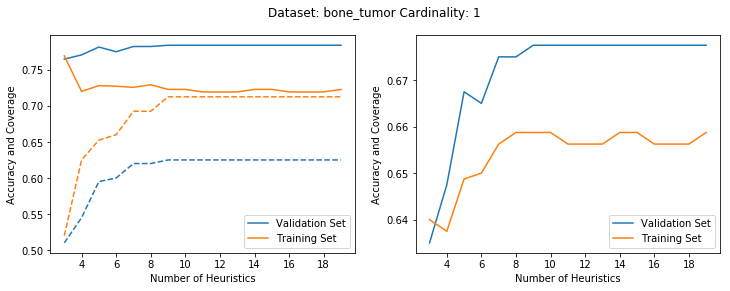

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(3,20),validation_accuracy, color='C0')
plt.plot(range(3,20),training_accuracy, color='C1')
plt.plot(range(3,20),validation_coverage, color='C0', linestyle='--')
plt.plot(range(3,20),training_coverage, color='C1', linestyle='--')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])

plt.subplot(1,2,2)
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(validation_accuracy,validation_coverage)] 
plt.plot(range(3,20),bm, color='C0')
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(training_accuracy,training_coverage)] 
plt.plot(range(3,20),bm, color='C1')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])
plt.suptitle('Dataset: ' + dataset + ' Cardinality: ' + str(c))

In [9]:
print "Program Synthesis Train Accuracy: ", np.max(training_accuracy)
print "Program Synthesis Validation Accuracy: ", np.max(validation_accuracy)

Program Synthesis Train Accuracy:  0.769230769231
Program Synthesis Validation Accuracy:  0.784


## Calculate Baselines

[**Decision Tree**](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Depth bound is unbounded, using default settings. Could do a finer comparison if needed.

In [10]:
from baselines.models import DecisionTree
dt = DecisionTree(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
dt.fit()
va,ta, vc, tc = dt.evaluate()
print "Decision Tree Train Accuracy: ", ta
print "Decision Tree Validation Accuracy: ", va

Decision Tree Train Accuracy:  0.6275
Decision Tree Validation Accuracy:  1.0


[**Boosting (AdaBoost)**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) No bound of the number of estimators yet, could bound by number of primitives for "fair" comparison?

In [11]:
from baselines.models import BoostClassifier
bc = BoostClassifier(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
bc.fit()
va,ta, vc, tc = bc.evaluate()
print "Boosting Train Accuracy: ", ta
print "Boosting Validation Accuracy: ", va

Boosting Train Accuracy:  0.6025
Boosting Validation Accuracy:  0.99


[**LabelPropagation (Normal Semi-Supervised)**](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading)
Semi-supervised method that is robust to noise. Fits with both the labeled and unlabeled examples

In [12]:
from baselines.models import SemiSupervised
ss = SemiSupervised(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
ss.fit()
va,ta, vc, tc = ss.evaluate()
print "SemiSupervised Train Accuracy: ", ta
print "SemiSupervised Validation Accuracy: ", va

SemiSupervised Train Accuracy:  0.65
SemiSupervised Validation Accuracy:  0.845


[**CPLE (Pessimistic Likelihood Estimation for Semi-Supervised)**](https://github.com/tmadl/semisup-learn) Based on the [model](https://arxiv.org/abs/1503.00269) that guarantees that adding in the unlabeled data points will not worsen only training with labeled examples

In [14]:
from baselines.models import ContrastiveSemiSupervised
css = ContrastiveSemiSupervised(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
css.fit()
va,ta, vc, tc = css.evaluate()
print "ContrastiveSemiSupervised Train Accuracy: ", ta
print "ContrastiveSemiSupervised Validation Accuracy: ", va

nn converged.
ContrastiveSemiSupervised Train Accuracy:  0.62
ContrastiveSemiSupervised Validation Accuracy:  0.705
